### Introduction

In this notebook we will do image captioning on Flickr 8K. We will be downloading the validation set, that contains around 41000 images for training. The data can be requested from from [here](https://forms.illinois.edu/sec/1713398). 

We will also use Keras for training. For converting the images to vectors we will use the VGG16, pretrained model in Keras

I will be following the instructions at [this](https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/) URL for this notebook.

I have downloaded and extracted the contents locally

- The image are kept in Flickr8k/Flicker8k_Dataset folder (8091 Images)
- The caption text files are kept in Flickr8k/Flickr8k_text

In [1]:
from keras.applications.vgg16 import VGG16
from keras.models import Model

model = VGG16()
#Pop off final layer, as if its a stack of layers with the head of the stack as the final layer
model.layers.pop()
model = Model(inputs = model.input, outputs = model.layers[-1].output)
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________


We see that the last layer in the summary is used to classify the image into 1000 classes. Our objective is not to classify but to get a vector representation of the image. We therefore want to pop the last layer of this model and need the final layer to be `fc2`, which gives us a vector of dimension  4096.

Check the summary below after we pop the final layer off

Each image has 4 descriptions. We will do the following

- Define a generator that will read the file line by line from the tokens file
- Split the content to have a tuple with key as image file name and value as the description.
- The description itself is not used as is but we convert to lowercase, remove punctuations, retain words with length greater than 1 character and number is alphabet. 
- Each caption will be prefixed with the the text startseq and end with endseq

In [2]:
import os
import string
local_dir = 'Flickr8k'
caption_file = os.path.join(local_dir, 'Flickr8k_text', 'Flickr8k.token.txt')

def caption_generator():
    trans = str.maketrans('', '', string.punctuation)
    with open(caption_file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            splits = line.split()
            name, *content = splits
            name = name.split('.')[0]
            content = [c.lower().translate(trans) for c in content if len(c) > 1 and c.isalpha()]
            yield (name, 'startseq ' + ' '.join(content) + ' endseq')

        
gen = caption_generator()
print('Showing first 10 entries as sample')
for _ in range(10):
    print(next(gen))

Showing first 10 entries as sample
('1000268201_693b08cb0e', 'startseq child in pink dress is climbing up set of stairs in an entry way endseq')
('1000268201_693b08cb0e', 'startseq girl going into wooden building endseq')
('1000268201_693b08cb0e', 'startseq little girl climbing into wooden playhouse endseq')
('1000268201_693b08cb0e', 'startseq little girl climbing the stairs to her playhouse endseq')
('1000268201_693b08cb0e', 'startseq little girl in pink dress going into wooden cabin endseq')
('1001773457_577c3a7d70', 'startseq black dog and spotted dog are fighting endseq')
('1001773457_577c3a7d70', 'startseq black dog and dog playing with each other on the road endseq')
('1001773457_577c3a7d70', 'startseq black dog and white dog with brown spots are staring at each other in the street endseq')
('1001773457_577c3a7d70', 'startseq two dogs of different breeds looking at each other on the road endseq')
('1001773457_577c3a7d70', 'startseq two dogs on pavement moving toward each other en


Now with the each image having multiple captions, let us group them by the image id and the value as the list of captions.

In [3]:
from itertools import groupby

grouped = groupby(caption_generator(), lambda x: x[0])

# group by generates a key, which is the 0th element of tuple, which is defined using the lambda function
# the value is a sequence of tuples with that key, since we are interested in the caption, we need another 
# generator to ignore the key and just extract the value
caption_dict = {k: [t for _, t in v] for k, v in grouped}

print('Number of unique imageids in are', len(caption_dict))

sample_keys = ['1000268201_693b08cb0e', '1001773457_577c3a7d70']

print('Getting captions for some sample image ids')
for k in sample_keys:
    print('\nImage id is', k, 'captions are')
    print('\n\t-> %s'%'\n\t-> '.join(caption_dict[k]))


Number of unique imageids in are 8092
Getting captions for some sample image ids

Image id is 1000268201_693b08cb0e captions are

	-> startseq child in pink dress is climbing up set of stairs in an entry way endseq
	-> startseq girl going into wooden building endseq
	-> startseq little girl climbing into wooden playhouse endseq
	-> startseq little girl climbing the stairs to her playhouse endseq
	-> startseq little girl in pink dress going into wooden cabin endseq

Image id is 1001773457_577c3a7d70 captions are

	-> startseq black dog and spotted dog are fighting endseq
	-> startseq black dog and dog playing with each other on the road endseq
	-> startseq black dog and white dog with brown spots are staring at each other in the street endseq
	-> startseq two dogs of different breeds looking at each other on the road endseq
	-> startseq two dogs on pavement moving toward each other endseq


 At this point we have a dictionary of image id and list of cleaned up captions. The number of files in the filesystem(my downloaded archive) however are 8091 but we have 8092 images, we perhaps have an image missing.

We will now build a vocabulary set where we iterate through all the items in the dictionary and find unique number of words in our vocabulary



In [4]:
vocabulary = set([split \
     for _, image_captions in caption_dict.items() \
     for caption in image_captions \
     for split in caption.split()])

#Add 1 as later the tokenizer will be generating 1 based index for words in vocabulary
vocab_size = len(vocabulary) + 1
print('Vocabulary is of length', vocab_size)

Vocabulary is of length 8360


We will now load the train, dev,  and test dataset labels in three lists

- train_images: List of training images
- test_images: List of training images
- dev_images: List of training images

The ids in these are same as the keys in the captions dictionary

We will also define a method which, given an image id will print the captions and the image for that id.

In [5]:
def load_image_ids(id_file):
    with open(id_file, 'r') as f:
        lines = f.readlines()
        return [line.split('.')[0] for line in lines]


dev_images = load_image_ids(os.path.join(local_dir, 'Flickr8k_text', 'Flickr_8k.devImages.txt'))
train_images = load_image_ids(os.path.join(local_dir, 'Flickr8k_text', 'Flickr_8k.trainImages.txt'))
test_images = load_image_ids(os.path.join(local_dir, 'Flickr8k_text', 'Flickr_8k.testImages.txt'))

print('%d Train images ids loaded'%len(train_images))
print('%d Dev images ids loaded'%len(dev_images))
print('%d Test images ids loaded'%len(test_images))


6000 Train images ids loaded
1000 Dev images ids loaded
1000 Test images ids loaded



Lets view few images with caption


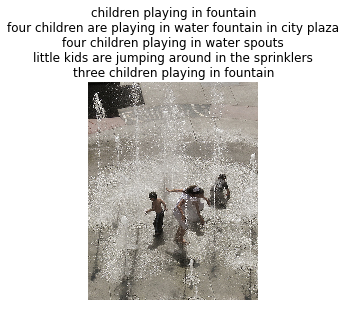

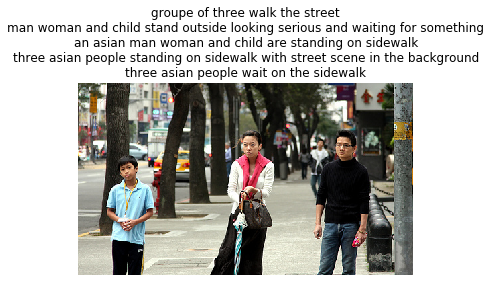

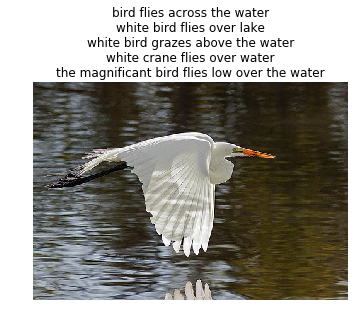

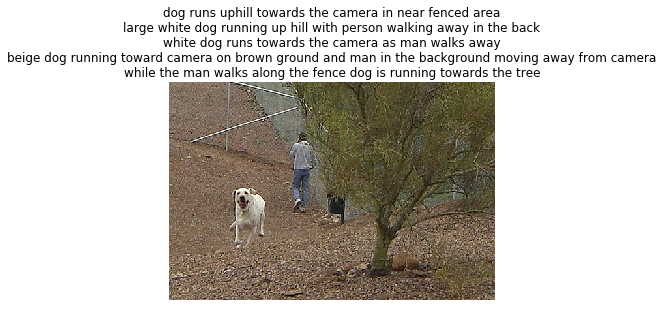

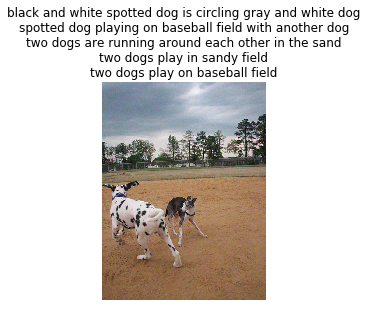

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import random

def show_image_with_captions(image_id, captions_dictionary, image_base_dir, image_extn = '.jpg'):
    im = Image.open(os.path.join(image_base_dir, image_id + image_extn))
    fig = plt.imshow(im)
    ax = plt.gca()
    
    captions = list(map(lambda x: ' '.join(x.split()[1:-1]), captions_dictionary[image_id]))
    
    ax.set_title('\n'.join(captions))
    plt.axis('off');
    plt.show()


random.seed(100)
random_5 = [ random.choice(train_images) for _ in range(5)]

image_base_dir = os.path.join(local_dir, 'Flickr8k_Dataset')
for img_id in random_5:
    show_image_with_captions(img_id, caption_dict, image_base_dir)
    


Next step is to iterate through all images in the dataset and create a dictionary of the image vectors

In [7]:
import numpy as np
from pickle import dump, load
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
import os

def load_image_feature_vectors(image_ids, image_base_dir, image_extn = '.jpg', feature_vector_pickle_file = 'features.pkl'):

    if os.path.exists(feature_vector_pickle_file):
        print('Found pickle file, loading dictionary from it')
        with open(feature_vector_pickle_file, 'rb') as f:
            features = load(f)
            
        print('Loaded features')
        
    else:
        print('Pickle file not found, building feature vectors for %d images, this may take long'%len(image_ids))
        features = dict()
        print('Generating image vectors\n')
        progress_num_images = len(image_ids) // 10
        for idx, image_id in enumerate(image_ids):
            img_file = os.path.join(image_base_dir, image_id + '.jpg')
            if not os.path.exists(img_file):
                print('Image file', img_file, 'doest not exist')
                continue

            #1. Load raw image
            img = load_img(img_file, target_size = (224, 224))
            #2. Convert to numpy array
            img = img_to_array(img)
            #3. Reshape as per the requirement of VGG16 Model
            img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
            #4. Preprocess the input feed into the predict function of the model            
            img = preprocess_input(img)
            
            img_vector = model.predict(img, verbose = 0)
            features[image_id] = img_vector
            if idx > 0 and idx % progress_num_images == 0:
                print('Processed %d images'%idx)

        with open(feature_vector_pickle_file, 'wb') as f:
            dump(features, f)

        print('Constructed and stored features for %d images'%len(features))
            
    return features

features = load_image_feature_vectors(dev_images + train_images + test_images, image_base_dir)

Found pickle file, loading dictionary from it
Loaded features



- `caption_dict`: Dictionary storing image id as key and list of caption as the value
- `dev_images`: List of dev image ids
- `train_images`: List of train image ids
- `test_images`: List of test image ids
- `features`: Dictionary storing image id as the key and the feature vector as the value

In [8]:
image_id = dev_images[0]
print('Image id is', image_id)
print('Image captions are\n\t:', '\n\t: '.join(caption_dict[image_id]))
print('Image vector dimension is', features[image_id].shape)

Image id is 2090545563_a4e66ec76b
Image captions are
	: startseq the boy laying face down on skateboard is being pushed along the ground by another boy endseq
	: startseq two girls play on skateboard in courtyard endseq
	: startseq two people play on long skateboard endseq
	: startseq two small children in red shirts playing on skateboard endseq
	: startseq two young children on skateboard going across sidewalk endseq
Image vector dimension is (1, 4096)



Let us create a keras tokenizer.
The tokenizer essentially does a similar activity as we did with Counter in last well and gives us some utility functions to convert sentences to numeric vectors

In [9]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts([caption for k in caption_dict for caption in caption_dict[k]])

print('Trying sample invocation of tokenizer.texts_to_sequences')
print('Tokenizer has', len(tokenizer.word_index), 'words')
print('Input text sentence is "', caption_dict[image_id][0], '"')
print('Sample tokenized representation of the word is', tokenizer.texts_to_sequences([caption_dict[image_id][0]])[0])

Trying sample invocation of tokenizer.texts_to_sequences
Tokenizer has 8359 words
Input text sentence is " startseq the boy laying face down on skateboard is being pushed along the ground by another boy endseq "
Sample tokenized representation of the word is [1, 4, 15, 262, 122, 35, 5, 133, 6, 173, 1622, 112, 4, 167, 53, 69, 15, 2]



With the Tokenizer in place, we will now prepare the required input

Suppose we have the the input `little girl running in field` and an input vector, we will train the neural network with the following inputs


|X1       | X2                                                       |Label|
|---------|:----------------------------------------------------------|-----|
|Image| startseq                                                     |little|
|Image| startseq,little                                              |girl|
|Image| startseq,little,girl                                         |running|
|Image| startseq,little,girl,running                                 |in|
|Image| startseq,little, girl, running, in                           |field|
|Image| startseq,little, girl, running, in,field                     |endseq|

We will define a function that will generate similar sequences for each image, but prior to that we will go through all the captions and find the max length caption.

In [10]:
max_seq_length = \
    max([len(caption.split()) for k in caption_dict for caption in caption_dict[k]])


print('Maximum sequence length is', max_seq_length)

Maximum sequence length is 33


In [11]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model

def create_sequences(key, features, caption_dict, tokenizer, max_seq_length, vocab_size):
    X1, X2, X3 = list(), list(), list()
    image = features[key]    
    #For each caption of the image, generate a sequence   
    for seq in tokenizer.texts_to_sequences(caption_dict[key]):
        for i in range(1, len(seq)):
            X1.append(image[0])
            X2.append(pad_sequences([seq[:i]], maxlen = max_seq_length)[0])
            X3.append(to_categorical([seq[i]], num_classes = vocab_size)[0])

    return np.array(X1), np.array(X2), np.array(X3)


We will define a generator that will generate the training samples

In [12]:
def data_generator(image_ids, features, caption_dict, tokenizer, max_seq_length, vocab_size):
    # loop for ever over images
    while 1:
        for key in image_ids:
            # retrieve the photo feature
            in_img, in_seq, out_word = create_sequences(key, 
                                                        features, 
                                                        caption_dict, 
                                                        tokenizer, 
                                                        max_seq_length,
                                                        vocab_size)

            yield [[in_img, in_seq], out_word]

Let us look at how the samples generated by generator look like, the content on the left of -> is the input and on the right is output

In [13]:
gen = data_generator(train_images, 
                           features, 
                           caption_dict, 
                           tokenizer, 
                           max_seq_length,
                           vocab_size)

for i in range(2):
    [img, inseq], outword = next(gen)
    print('-'*80)
    print('\ni:', i, 'Image shape is', img.shape)
    print('i:', i, 'Input Sequence shape is', inseq.shape)
    print('i:', i, 'Output shape is', outword.shape)    
    print('-'*80)
    for idx in range(len(inseq)):        
        print('[IMG],', tokenizer.sequences_to_texts([inseq[idx]])[0],  '->', 
              tokenizer.sequences_to_texts([[np.argmax(outword[idx])]])[0])
    

--------------------------------------------------------------------------------

i: 0 Image shape is (47, 4096)
i: 0 Input Sequence shape is (47, 33)
i: 0 Output shape is (47, 8360)
--------------------------------------------------------------------------------
[IMG], startseq -> black
[IMG], startseq black -> dog
[IMG], startseq black dog -> is
[IMG], startseq black dog is -> running
[IMG], startseq black dog is running -> after
[IMG], startseq black dog is running after -> white
[IMG], startseq black dog is running after white -> dog
[IMG], startseq black dog is running after white dog -> in
[IMG], startseq black dog is running after white dog in -> the
[IMG], startseq black dog is running after white dog in the -> snow
[IMG], startseq black dog is running after white dog in the snow -> endseq
[IMG], startseq -> black
[IMG], startseq black -> dog
[IMG], startseq black dog -> chasing
[IMG], startseq black dog chasing -> brown
[IMG], startseq black dog chasing brown -> dog
[IMG], sta

The above content looks convincing, Create a function to build a model

In [14]:
from keras.layers import Dense, Dropout, Embedding, LSTM, Input
from keras.layers.merge import add

def define_model(vocab_size, max_seq_length, input_image_dim = 4096, hidden_layer_dim = 256):

    #Input Model
    input1 = Input(shape = (input_image_dim, ))
    fe1 = Dropout(0.5)(input1)
    fe2 = Dense(hidden_layer_dim, activation='relu')(fe1)
    
    #Sequence Model
    input2 = Input(shape=(max_seq_length,))
    se1 = Embedding(vocab_size, hidden_layer_dim, mask_zero = True)(input2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    
    #Decoder Model    
    decoder1 = add([fe2, se3])
    decoder2 = Dense(hidden_layer_dim, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    #Tie these three all together    
    model = Model(inputs=[input1, input2], outputs = outputs)
    print(model.summary())
    model.compile(loss='categorical_crossentropy', optimizer = 'adam')
    return model

Below function takes a model and generates a sequence for the given image id

In [15]:
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_id, features, caption_dict, model, tokenizer, max_seq_length,\
                     image_base_dir, image_extn = '.jpg'):
    
    image = Image.open(os.path.join(image_base_dir, image_id + image_extn))
    
    plt.imshow(image)
    plt.axis('off')
    
    actual_captions = list(map(lambda x: ' '.join(x.split()[1:-1]), caption_dict[image_id]))
    print('Actual titles are \n\t:"%s"'%'\n\t: '.join(actual_captions))
    
    start_seq_idx = tokenizer.word_index['startseq']
    end_seq_idx = tokenizer.word_index['endseq']
    
    sent_len = 1
    curr_word = start_seq_idx
    
    input_padded_sentence = np.zeros(max_seq_length, dtype = np.int32)
    input_padded_sentence[-1] = start_seq_idx    
    image_feature = features[image_id]
    
    while sent_len < max_seq_length and curr_word != end_seq_idx: 
        sent_len += 1
        curr_word = np.argmax(model.predict([[features[image_id][0]], [input_padded_sentence]], verbose = 0))        
        input_padded_sentence = np.roll(input_padded_sentence, shift = -1)
        input_padded_sentence[-1] = curr_word

    input_padded_sentence[input_padded_sentence == 1] = 0
    print('\nGenerated caption is "%s"'%tokenizer.sequences_to_texts([input_padded_sentence[1:-1]])[0])
    
    plt.show()

    

In [16]:
import os
from keras.models import load_model


def train_model(data_generator, max_seq_length, train_dataset_size, num_epochs = 20, savefile = 'image-captioning-model-save.h5'):
    
    # data_generator: The generator that generates the training data and output labels
    # train_dataset_size: Size of the training data required for printing the progress of the training as we provide 
    # keras with the data generator
    # num_epochs: Total number of epochs to run

    if os.path.exists(savefile):
        print('Found pretrained model, using it to resume training')
        model = load_model(savefile)
    else:
        print('No existing model found, creating a new one')
        model = define_model(vocab_size, max_seq_length)
        
    print('Starting training, num_epochs = %d'%num_epochs)
    
    for e in range(num_epochs):
        gen = data_generator()
        
        print('\n')
        print('-'* 80)
        print('Generating a caption for 3 test image after epoch %d'%e)
        for i in range(3):
            generate_caption(dev_images[i], features, caption_dict, model, tokenizer, max_seq_length,\
                     image_base_dir)
        print('-'* 80)
        
        # fit model
        model.fit_generator(gen, epochs = 1, steps_per_epoch = train_dataset_size, verbose = 1)
        model.save(savefile)
        
    
    
    return model


def compute_training_data_size(image_ids, caption_dict):
    return sum([len(caption.split()) for img_id in image_ids for caption in caption_dict[img_id]])



Start Training

In [17]:
train_dataset_size = compute_training_data_size(train_images, caption_dict)
model = train_model(data_generator = 
                    lambda: data_generator(train_images, 
                                           features, 
                                           caption_dict, 
                                           tokenizer, 
                                           max_seq_length,
                                           vocab_size), 
                    train_dataset_size = train_dataset_size,
                    max_seq_length = max_seq_length,
                    #num_epochs = 5)
                    num_epochs = 0)


Found pretrained model, using it to resume training
Starting training, num_epochs = 0



We will now evaluate the model using Bleu score

In [19]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import corpus_bleu

def generate_caption(image_id, features, caption_dict, model, tokenizer, max_seq_length,\
                     image_base_dir, image_extn = '.jpg'):
    
    
    start_seq_idx = tokenizer.word_index['startseq']
    end_seq_idx = tokenizer.word_index['endseq']
    
    sent_len = 1
    curr_word = start_seq_idx
    
    seq = tokenizer.texts_to_sequences(['startseq'])[0]
    input_padded_sentence = pad_sequences([seq], maxlen = max_seq_length)
    
    while sent_len < max_seq_length and curr_word != end_seq_idx: 
        sent_len += 1
        yhat = model.predict([features[image_id], input_padded_sentence], verbose = 0)
        curr_word = np.argmax(yhat) 
        input_padded_sentence[0] = np.roll(input_padded_sentence[0], shift = -1)
        input_padded_sentence[0][-1] = curr_word
        

    return tokenizer.sequences_to_texts(input_padded_sentence)[0]


def evaluate_model(images, model, features, caption_dict, tokenizer, max_seq_length, image_base_dir):
    actual, predicted = list(), list()
    # step over the whole set
    for image_id in images:
        actual_captions = list(map(lambda x: ' '.join(x.split()[1:-1]), caption_dict[image_id]))
        # generate description
        yhat = generate_caption(image_id, features, caption_dict, model, tokenizer, max_seq_length, image_base_dir)
        # store actual and predicted
        references = [d.split() for d in actual_captions]
        actual.append(references)
        predicted.append(yhat.split())
        
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
    
evaluate_model(test_images, model, features, caption_dict, tokenizer, max_seq_length, image_base_dir)

BLEU-1: 0.315163
BLEU-2: 0.141989
BLEU-3: 0.083778
BLEU-4: 0.028263



The BLEU Scores are very low and lot of work will ne needed for to improve it further. The captions generated doesn't seem to be generalized and starts generating similar captions.

Lets look at few examples below